## Twitter User Gender Prediction

Given *data about users on Twitter*, let's try to predict the **gender** of a given user.

We will use a deep recurrent neural network with multiple inputs to make our predictions.

Data source: https://www.kaggle.com/datasets/crowdflower/twitter-user-gender-classification

### Importing Libraries

In [7]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.simplefilter('ignore')

In [8]:
data = pd.read_csv('gender-classifier-DFE-791531.csv', encoding='latin-1')
data

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20045,815757572,True,golden,259,NaN,female,1.0000,yes,1.0,8/5/15 21:16,(rp),302,female,0084B4,capuletrosa,yes,https://pbs.twimg.com/profile_images/656793310...,0,C0DEED,"@lookupondeath ...Fine, and I'll drink tea too...",NaN,783,10/26/15 13:20,6.587400e+17,Verona ªÁ,NaN
20046,815757681,True,golden,248,NaN,male,1.0000,yes,1.0,8/15/12 21:17,"Whatever you like, it's not a problem at all. ...",2513,male,CFB929,BenNight41,yes,https://pbs.twimg.com/profile_images/639815429...,0,0,Greg Hardy you a good player and all but don't...,NaN,13523,10/26/15 12:40,6.587300e+17,"Kansas City, MO",NaN
20047,815757830,True,golden,264,NaN,male,1.0000,yes,1.0,9/3/12 1:17,#TeamBarcelona ..You look lost so you should f...,50,male,0084B4,realuzzyfluxz,yes,https://pbs.twimg.com/profile_images/655473271...,0,C0DEED,You can miss people and still never want to se...,NaN,26419,10/26/15 13:20,6.587400e+17,Lagos Nigeria,NaN
20048,815757921,True,golden,250,NaN,female,0.8489,yes,1.0,11/6/12 23:46,Anti-statist; I homeschool my kids. Aspiring t...,70804,female,9266CC,argumatronic,yes,https://pbs.twimg.com/profile_images/657716093...,0,0,@bitemyapp i had noticed your tendency to pee ...,NaN,56073,10/26/15 12:40,6.587300e+17,Texas Hill Country,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

### Preprocessing

In [12]:
df = data.copy()

In [13]:
# Percentages of missing values
df.isna().mean()*100

_unit_id                  0.000000
_golden                   0.000000
_unit_state               0.000000
_trusted_judgments        0.000000
_last_judgment_at         0.249377
gender                    0.483791
gender:confidence         0.129676
profile_yn                0.000000
profile_yn:confidence     0.000000
created                   0.000000
description              18.673317
fav_number                0.000000
gender_gold              99.750623
link_color                0.000000
name                      0.000000
profile_yn_gold          99.750623
profileimage              0.000000
retweet_count             0.000000
sidebar_color             0.000000
text                      0.000000
tweet_coord              99.206983
tweet_count               0.000000
tweet_created             0.000000
tweet_id                  0.000000
tweet_location           37.331671
user_timezone            38.892768
dtype: float64

In [15]:
# Drop unnecessary columns
df = df.drop(['_unit_id', 'name', 'profileimage', 'tweet_id'], axis=1)

In [16]:
df.isna().mean()*100

_golden                   0.000000
_unit_state               0.000000
_trusted_judgments        0.000000
_last_judgment_at         0.249377
gender                    0.483791
gender:confidence         0.129676
profile_yn                0.000000
profile_yn:confidence     0.000000
created                   0.000000
description              18.673317
fav_number                0.000000
gender_gold              99.750623
link_color                0.000000
profile_yn_gold          99.750623
retweet_count             0.000000
sidebar_color             0.000000
text                      0.000000
tweet_coord              99.206983
tweet_count               0.000000
tweet_created             0.000000
tweet_location           37.331671
user_timezone            38.892768
dtype: float64

In [17]:
# Encode unknown values in the target column as np.NaN
df['gender'] = df['gender'].replace('unknown', np.NaN)

In [18]:
df['gender'].unique()

array(['male', 'female', 'brand', nan], dtype=object)

In [19]:
# Drop rows with missing target values
gender_nans = df[df['gender'].isna()].index
df = df.drop(gender_nans, axis=0).reset_index(drop=True)

In [20]:
df['gender'].unique()

array(['male', 'female', 'brand'], dtype=object)

In [21]:
df.shape

(18836, 22)

In [22]:
df.columns[df.isna().mean() > 0.3]

Index(['gender_gold', 'profile_yn_gold', 'tweet_coord', 'tweet_location',
       'user_timezone'],
      dtype='object')

In [23]:
# Drop columns with over 30% missing values
missing_cols = df.columns[df.isna().mean() > 0.3]
df = df.drop(missing_cols, axis=1)
df

,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,link_color,retweet_count,sidebar_color,text,tweet_count,tweet_created
0,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,08C2C2,0,FFFFFF,Robbie E Responds To Critics After Win Against...,110964,10/26/15 12:40
1,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,0084B4,0,C0DEED,ÛÏIt felt like they were my friends and I was...,7471,10/26/15 12:40
2,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,ABB8C2,1,C0DEED,i absolutely adore when louis starts the songs...,5617,10/26/15 12:40
3,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0084B4,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,1693,10/26/15 12:40
4,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,3B94D9,0,0,Watching Neighbours on Sky+ catching up with t...,31462,10/26/15 12:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18831,True,golden,259,NaN,female,1.0000,yes,1.0,8/5/15 21:16,(rp),302,0084B4,0,C0DEED,"@lookupondeath ...Fine, and I'll drink tea too...",783,10/26/15 13:20
18832,True,golden,248,NaN,male,1.0000,yes,1.0,8/15/12 21:17,"Whatever you like, it's not a problem at all. ...",2513,CFB929,0,0,Greg Hardy you a good player and all but don't...,13523,10/26/15 12:40
18833,True,golden,264,NaN,male,1.0000,yes,1.0,9/3/12 1:17,#TeamBarcelona ..You look lost so you should f...,50,0084B4,0,C0DEED,You can miss people and still never want to se...,26419,10/26/15 13:20
18834,True,golden,250,NaN,female,0.8489,yes,1.0,11/6/12 23:46,Anti-statist; I homeschool my kids. Aspiring t...,70804,9266CC,0,0,@bitemyapp i had noticed your tendency to pee ...,56073,10/26/15 12:40


In [24]:
df.isna().sum()

_golden                     0
_unit_state                 0
_trusted_judgments          0
_last_judgment_at          50
gender                      0
gender:confidence           0
profile_yn                  0
profile_yn:confidence       0
created                     0
description              3314
fav_number                  0
link_color                  0
retweet_count               0
sidebar_color               0
text                        0
tweet_count                 0
tweet_created               0
dtype: int64

In [27]:
# There are only 50 remaining missing values in the _last_judgment_at columns, so let's drop those rows
judgment_nans = df[df['_last_judgment_at'].isna()].index
df = df.drop(judgment_nans, axis=0).reset_index(drop=True)

In [28]:
df.isna().sum()

_golden                     0
_unit_state                 0
_trusted_judgments          0
_last_judgment_at           0
gender                      0
gender:confidence           0
profile_yn                  0
profile_yn:confidence       0
created                     0
description              3308
fav_number                  0
link_color                  0
retweet_count               0
sidebar_color               0
text                        0
tweet_count                 0
tweet_created               0
dtype: int64

In [29]:
# Let's encode the missing values in the description column as empty strings
df['description'] = df['description'].fillna('')

In [30]:
df.isna().sum()

_golden                  0
_unit_state              0
_trusted_judgments       0
_last_judgment_at        0
gender                   0
gender:confidence        0
profile_yn               0
profile_yn:confidence    0
created                  0
description              0
fav_number               0
link_color               0
retweet_count            0
sidebar_color            0
text                     0
tweet_count              0
tweet_created            0
dtype: int64

In [31]:
df

,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,link_color,retweet_count,sidebar_color,text,tweet_count,tweet_created
0,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,08C2C2,0,FFFFFF,Robbie E Responds To Critics After Win Against...,110964,10/26/15 12:40
1,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,0084B4,0,C0DEED,ÛÏIt felt like they were my friends and I was...,7471,10/26/15 12:40
2,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,ABB8C2,1,C0DEED,i absolutely adore when louis starts the songs...,5617,10/26/15 12:40
3,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0084B4,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,1693,10/26/15 12:40
4,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,3B94D9,0,0,Watching Neighbours on Sky+ catching up with t...,31462,10/26/15 12:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18781,False,finalized,3,10/26/15 23:04,male,1.0000,yes,1.0,1/24/13 11:55,XXI,33834,ABB8C2,1,0,Seriously love Trent and Justin. Would do anyt...,29190,10/26/15 13:18
18782,False,finalized,3,10/27/15 1:40,male,1.0000,yes,1.0,12/19/14 13:54,607. Money in the making. Take it a day at a t...,2462,0084B4,0,C0DEED,One person can look at you like your the most ...,11117,10/26/15 13:18
18783,False,finalized,3,10/27/15 0:03,female,1.0000,yes,1.0,4/15/15 19:15,I can quote (Insert movie) better than you and...,1855,664422,0,0,These 24 Wedding Photobombs Made The Bride And...,5640,10/26/15 13:18
18784,False,finalized,3,10/26/15 22:27,female,0.6593,yes,1.0,4/6/15 13:43,| Kingdom Hearts | Alice | Sims | Minecraft | ...,2160,05B8CC,0,0,So I am riding around and I saw a horse runnin...,2041,10/26/15 13:18


In [33]:
# Create date/time columns
for column in ['_last_judgment_at', 'created', 'tweet_created']:
    df[column] = pd.to_datetime(df[column])

In [34]:
df['judgement_year'] = df['_last_judgment_at'].dt.year
df['judgement_month'] = df['_last_judgment_at'].dt.month
df['judgement_day'] = df['_last_judgment_at'].dt.day
df['judgement_hour'] = df['_last_judgment_at'].dt.hour

In [36]:
df['created_year'] = df['created'].dt.year
df['created_month'] = df['created'].dt.month
df['created_day'] = df['created'].dt.day
df['create_hour'] = df['created'].dt.hour

In [37]:
df['tweet_year'] = df['tweet_created'].dt.year
df['tweet_month'] = df['tweet_created'].dt.month
df['tweet_day'] = df['tweet_created'].dt.day
df['tweet_hour'] = df['tweet_created'].dt.hour

In [38]:
df

,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,link_color,retweet_count,sidebar_color,text,tweet_count,tweet_created,judgement_year,judgement_month,judgement_day,judgement_hour,created_year,created_month,created_day,create_hour,tweet_year,tweet_month,tweet_day,tweet_hour
0,False,finalized,3,2015-10-26 23:24:00,male,1.0000,yes,1.0,2013-12-05 01:48:00,i sing my own rhythm.,0,08C2C2,0,FFFFFF,Robbie E Responds To Critics After Win Against...,110964,2015-10-26 12:40:00,2015,10,26,23,2013,12,5,1,2015,10,26,12
1,False,finalized,3,2015-10-26 23:30:00,male,1.0000,yes,1.0,2012-10-01 13:51:00,I'm the author of novels filled with family dr...,68,0084B4,0,C0DEED,ÛÏIt felt like they were my friends and I was...,7471,2015-10-26 12:40:00,2015,10,26,23,2012,10,1,13,2015,10,26,12
2,False,finalized,3,2015-10-26 23:33:00,male,0.6625,yes,1.0,2014-11-28 11:30:00,louis whining and squealing and all,7696,ABB8C2,1,C0DEED,i absolutely adore when louis starts the songs...,5617,2015-10-26 12:40:00,2015,10,26,23,2014,11,28,11,2015,10,26,12
3,False,finalized,3,2015-10-26 23:10:00,male,1.0000,yes,1.0,2009-06-11 22:39:00,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0084B4,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,1693,2015-10-26 12:40:00,2015,10,26,23,2009,6,11,22,2015,10,26,12
4,False,finalized,3,2015-10-27 01:15:00,female,1.0000,yes,1.0,2014-04-16 13:23:00,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,3B94D9,0,0,Watching Neighbours on Sky+ catching up with t...,31462,2015-10-26 12:40:00,2015,10,27,1,2014,4,16,13,2015,10,26,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18781,False,finalized,3,2015-10-26 23:04:00,male,1.0000,yes,1.0,2013-01-24 11:55:00,XXI,33834,ABB8C2,1,0,Seriously love Trent and Justin. Would do anyt...,29190,2015-10-26 13:18:00,2015,10,26,23,2013,1,24,11,2015,10,26,13
18782,False,finalized,3,2015-10-27 01:40:00,male,1.0000,yes,1.0,2014-12-19 13:54:00,607. Money in the making. Take it a day at a t...,2462,0084B4,0,C0DEED,One person can look at you like your the most ...,11117,2015-10-26 13:18:00,2015,10,27,1,2014,12,19,13,2015,10,26,13
18783,False,finalized,3,2015-10-27 00:03:00,female,1.0000,yes,1.0,2015-04-15 19:15:00,I can quote (Insert movie) better than you and...,1855,664422,0,0,These 24 Wedding Photobombs Made The Bride And...,5640,2015-10-26 13:18:00,2015,10,27,0,2015,4,15,19,2015,10,26,13
18784,False,finalized,3,2015-10-26 22:27:00,female,0.6593,yes,1.0,2015-04-06 13:43:00,| Kingdom Hearts | Alice | Sims | Minecraft | ...,2160,05B8CC,0,0,So I am riding around and I saw a horse runnin...,2041,2015-10-26 13:18:00,2015,10,26,22,2015,4,6,13,2015,10,26,13


In [39]:
df = df.drop(['_last_judgment_at', 'created', 'tweet_created'], axis=1)
df

,_golden,_unit_state,_trusted_judgments,gender,gender:confidence,profile_yn,profile_yn:confidence,description,fav_number,link_color,retweet_count,sidebar_color,text,tweet_count,judgement_year,judgement_month,judgement_day,judgement_hour,created_year,created_month,created_day,create_hour,tweet_year,tweet_month,tweet_day,tweet_hour
0,False,finalized,3,male,1.0000,yes,1.0,i sing my own rhythm.,0,08C2C2,0,FFFFFF,Robbie E Responds To Critics After Win Against...,110964,2015,10,26,23,2013,12,5,1,2015,10,26,12
1,False,finalized,3,male,1.0000,yes,1.0,I'm the author of novels filled with family dr...,68,0084B4,0,C0DEED,ÛÏIt felt like they were my friends and I was...,7471,2015,10,26,23,2012,10,1,13,2015,10,26,12
2,False,finalized,3,male,0.6625,yes,1.0,louis whining and squealing and all,7696,ABB8C2,1,C0DEED,i absolutely adore when louis starts the songs...,5617,2015,10,26,23,2014,11,28,11,2015,10,26,12
3,False,finalized,3,male,1.0000,yes,1.0,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0084B4,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,1693,2015,10,26,23,2009,6,11,22,2015,10,26,12
4,False,finalized,3,female,1.0000,yes,1.0,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,3B94D9,0,0,Watching Neighbours on Sky+ catching up with t...,31462,2015,10,27,1,2014,4,16,13,2015,10,26,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18781,False,finalized,3,male,1.0000,yes,1.0,XXI,33834,ABB8C2,1,0,Seriously love Trent and Justin. Would do anyt...,29190,2015,10,26,23,2013,1,24,11,2015,10,26,13
18782,False,finalized,3,male,1.0000,yes,1.0,607. Money in the making. Take it a day at a t...,2462,0084B4,0,C0DEED,One person can look at you like your the most ...,11117,2015,10,27,1,2014,12,19,13,2015,10,26,13
18783,False,finalized,3,female,1.0000,yes,1.0,I can quote (Insert movie) better than you and...,1855,664422,0,0,These 24 Wedding Photobombs Made The Bride And...,5640,2015,10,27,0,2015,4,15,19,2015,10,26,13
18784,False,finalized,3,female,0.6593,yes,1.0,| Kingdom Hearts | Alice | Sims | Minecraft | ...,2160,05B8CC,0,0,So I am riding around and I saw a horse runnin...,2041,2015,10,26,22,2015,4,6,13,2015,10,26,13


In [45]:
def get_sequences(texts, vocab_length):
    tokenizer = Tokenizer(num_words=vocab_length)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    max_seq_length = np.max([len(sequence) for sequence in sequences])
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    return sequences

In [46]:
get_sequences(df['text'], vocab_length=10000)

array([[ 597,    6, 8149, ...,    0,    0,    0],
       [8150, 1097,   36, ...,    0,    0,    0],
       [   7, 1396, 6335, ...,    0,    0,    0],
       ...,
       [ 206,  917, 1212, ...,    0,    0,    0],
       [  27,    7,  148, ...,    0,    0,    0],
       [6097,  242,  397, ...,    0,    0,    0]], dtype=int32)

In [47]:
get_sequences(df['text'], vocab_length=10000).shape

(18786, 104)

In [48]:
# Get sequence data for the description and text columns
desc = get_sequences(df['description'], vocab_length=20000)
tweets = get_sequences(df['text'], vocab_length=20000)

df = df.drop(['description', 'text'], axis=1)

In [49]:
df

,_golden,_unit_state,_trusted_judgments,gender,gender:confidence,profile_yn,profile_yn:confidence,fav_number,link_color,retweet_count,sidebar_color,tweet_count,judgement_year,judgement_month,judgement_day,judgement_hour,created_year,created_month,created_day,create_hour,tweet_year,tweet_month,tweet_day,tweet_hour
0,False,finalized,3,male,1.0000,yes,1.0,0,08C2C2,0,FFFFFF,110964,2015,10,26,23,2013,12,5,1,2015,10,26,12
1,False,finalized,3,male,1.0000,yes,1.0,68,0084B4,0,C0DEED,7471,2015,10,26,23,2012,10,1,13,2015,10,26,12
2,False,finalized,3,male,0.6625,yes,1.0,7696,ABB8C2,1,C0DEED,5617,2015,10,26,23,2014,11,28,11,2015,10,26,12
3,False,finalized,3,male,1.0000,yes,1.0,202,0084B4,0,C0DEED,1693,2015,10,26,23,2009,6,11,22,2015,10,26,12
4,False,finalized,3,female,1.0000,yes,1.0,37318,3B94D9,0,0,31462,2015,10,27,1,2014,4,16,13,2015,10,26,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18781,False,finalized,3,male,1.0000,yes,1.0,33834,ABB8C2,1,0,29190,2015,10,26,23,2013,1,24,11,2015,10,26,13
18782,False,finalized,3,male,1.0000,yes,1.0,2462,0084B4,0,C0DEED,11117,2015,10,27,1,2014,12,19,13,2015,10,26,13
18783,False,finalized,3,female,1.0000,yes,1.0,1855,664422,0,0,5640,2015,10,27,0,2015,4,15,19,2015,10,26,13
18784,False,finalized,3,female,0.6593,yes,1.0,2160,05B8CC,0,0,2041,2015,10,26,22,2015,4,6,13,2015,10,26,13


In [52]:
tweets.shape

(18786, 104)

In [53]:
desc.shape

(18786, 62)

In [54]:
{column: len(df[column].unique()) for column in df.columns}

{'_golden': 1,
 '_unit_state': 1,
 '_trusted_judgments': 1,
 'gender': 3,
 'gender:confidence': 873,
 'profile_yn': 1,
 'profile_yn:confidence': 219,
 'fav_number': 6551,
 'link_color': 2882,
 'retweet_count': 22,
 'sidebar_color': 545,
 'tweet_count': 13604,
 'judgement_year': 1,
 'judgement_month': 1,
 'judgement_day': 2,
 'judgement_hour': 6,
 'created_year': 10,
 'created_month': 12,
 'created_day': 31,
 'create_hour': 24,
 'tweet_year': 1,
 'tweet_month': 1,
 'tweet_day': 1,
 'tweet_hour': 2}

In [56]:
# Drop columns with only one value
df = df.drop(['_golden', 
              '_unit_state', 
              '_trusted_judgments', 
              'profile_yn', 
              'judgement_year', 
              'judgement_month', 
              'tweet_year', 
              'tweet_month',
              'tweet_day'], axis=1)
df

,gender,gender:confidence,profile_yn:confidence,fav_number,link_color,retweet_count,sidebar_color,tweet_count,judgement_day,judgement_hour,created_year,created_month,created_day,create_hour,tweet_hour
0,male,1.0000,1.0,0,08C2C2,0,FFFFFF,110964,26,23,2013,12,5,1,12
1,male,1.0000,1.0,68,0084B4,0,C0DEED,7471,26,23,2012,10,1,13,12
2,male,0.6625,1.0,7696,ABB8C2,1,C0DEED,5617,26,23,2014,11,28,11,12
3,male,1.0000,1.0,202,0084B4,0,C0DEED,1693,26,23,2009,6,11,22,12
4,female,1.0000,1.0,37318,3B94D9,0,0,31462,27,1,2014,4,16,13,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18781,male,1.0000,1.0,33834,ABB8C2,1,0,29190,26,23,2013,1,24,11,13
18782,male,1.0000,1.0,2462,0084B4,0,C0DEED,11117,27,1,2014,12,19,13,13
18783,female,1.0000,1.0,1855,664422,0,0,5640,27,0,2015,4,15,19,13
18784,female,0.6593,1.0,2160,05B8CC,0,0,2041,26,22,2015,4,6,13,13


In [57]:
def get_rgb(colors):
    r = colors.apply(lambda x: hex_to_decimal(x[0:2]))
    g = colors.apply(lambda x: hex_to_decimal(x[2:4]))
    b = colors.apply(lambda x: hex_to_decimal(x[4:6]))
    return r, g, b

def hex_to_decimal(x):
    try:
        return int(x, 16)
    except:
        return 0

In [58]:
# Encode color columns as RGB values
df['link_red'], df['link_green'], df['link_blue'] = get_rgb(df['link_color'])

In [60]:
df['side_red'], df['side_green'], df['side_blue'] = get_rgb(df['sidebar_color'])

In [62]:
df = df.drop(['link_color', 'sidebar_color'], axis=1)
df

,gender,gender:confidence,profile_yn:confidence,fav_number,retweet_count,tweet_count,judgement_day,judgement_hour,created_year,created_month,created_day,create_hour,tweet_hour,link_red,link_green,link_blue,side_red,side_green,side_blue
0,male,1.0000,1.0,0,0,110964,26,23,2013,12,5,1,12,8,194,194,255,255,255
1,male,1.0000,1.0,68,0,7471,26,23,2012,10,1,13,12,0,132,180,192,222,237
2,male,0.6625,1.0,7696,1,5617,26,23,2014,11,28,11,12,171,184,194,192,222,237
3,male,1.0000,1.0,202,0,1693,26,23,2009,6,11,22,12,0,132,180,192,222,237
4,female,1.0000,1.0,37318,0,31462,27,1,2014,4,16,13,12,59,148,217,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18781,male,1.0000,1.0,33834,1,29190,26,23,2013,1,24,11,13,171,184,194,0,0,0
18782,male,1.0000,1.0,2462,0,11117,27,1,2014,12,19,13,13,0,132,180,192,222,237
18783,female,1.0000,1.0,1855,0,5640,27,0,2015,4,15,19,13,102,68,34,0,0,0
18784,female,0.6593,1.0,2160,0,2041,26,22,2015,4,6,13,13,5,184,204,0,0,0


In [66]:
# Encode label column
label_mapping = {'female':0, 'male': 1, 'brand': 2}
df['gender'] = df['gender'].replace(label_mapping)

In [67]:
# Split df into X and y
y = df['gender'].copy()
X = df.drop('gender', axis=1).copy()

In [68]:
X

,gender:confidence,profile_yn:confidence,fav_number,retweet_count,tweet_count,judgement_day,judgement_hour,created_year,created_month,created_day,create_hour,tweet_hour,link_red,link_green,link_blue,side_red,side_green,side_blue
0,1.0000,1.0,0,0,110964,26,23,2013,12,5,1,12,8,194,194,255,255,255
1,1.0000,1.0,68,0,7471,26,23,2012,10,1,13,12,0,132,180,192,222,237
2,0.6625,1.0,7696,1,5617,26,23,2014,11,28,11,12,171,184,194,192,222,237
3,1.0000,1.0,202,0,1693,26,23,2009,6,11,22,12,0,132,180,192,222,237
4,1.0000,1.0,37318,0,31462,27,1,2014,4,16,13,12,59,148,217,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18781,1.0000,1.0,33834,1,29190,26,23,2013,1,24,11,13,171,184,194,0,0,0
18782,1.0000,1.0,2462,0,11117,27,1,2014,12,19,13,13,0,132,180,192,222,237
18783,1.0000,1.0,1855,0,5640,27,0,2015,4,15,19,13,102,68,34,0,0,0
18784,0.6593,1.0,2160,0,2041,26,22,2015,4,6,13,13,5,184,204,0,0,0


In [69]:
y

0        1
1        1
2        1
3        1
4        0
        ..
18781    1
18782    1
18783    0
18784    0
18785    2
Name: gender, Length: 18786, dtype: int64

In [70]:
# Scale X with Standardscaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [71]:
X

,gender:confidence,profile_yn:confidence,fav_number,retweet_count,tweet_count,judgement_day,judgement_hour,created_year,created_month,created_day,create_hour,tweet_hour,link_red,link_green,link_blue,side_red,side_green,side_blue
0,0.572304,0.127711,-0.353856,-0.030197,0.601703,-0.998086,1.038621,0.387867,1.741746,-1.247951,-1.869971,-1.006515,-0.652618,1.471536,0.668960,1.033061,0.820675,0.726157
1,0.572304,0.127711,-0.348401,-0.030197,-0.265987,-0.998086,1.038621,-0.075119,1.129840,-1.708550,0.166174,-1.006515,-0.744239,0.267859,0.474240,0.342076,0.479470,0.547354
2,-1.377855,0.127711,0.263524,0.335319,-0.281531,-0.998086,1.038621,0.850852,1.435793,1.400491,-0.173183,-1.006515,1.214150,1.277394,0.668960,0.342076,0.479470,0.547354
3,0.572304,0.127711,-0.337651,-0.030197,-0.314430,-0.998086,1.038621,-1.464075,-0.093971,-0.557053,1.693283,-1.006515,-0.744239,0.267859,0.474240,0.342076,0.479470,0.547354
4,0.572304,0.127711,2.639827,-0.030197,-0.064846,1.001918,-0.964719,0.850852,-0.705877,0.018695,0.166174,-1.006515,-0.068537,0.578485,0.988857,-1.763781,-1.815909,-1.806887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18781,0.572304,0.127711,2.360338,0.335319,-0.083894,-0.998086,1.038621,0.387867,-1.623736,0.939893,-0.173183,0.993527,1.214150,1.277394,0.668960,-1.763781,-1.815909,-1.806887
18782,0.572304,0.127711,-0.156352,-0.030197,-0.235419,1.001918,-0.964719,0.850852,1.741746,0.364144,0.166174,0.993527,-0.744239,0.267859,0.474240,0.342076,0.479470,0.547354
18783,0.572304,0.127711,-0.205046,-0.030197,-0.281338,1.001918,-1.055780,1.313838,-0.705877,-0.096455,1.184247,0.993527,0.423923,-0.974647,-1.556412,-1.763781,-1.815909,-1.806887
18784,-1.396345,0.127711,-0.180579,-0.030197,-0.311512,-0.998086,0.947560,1.313838,-0.705877,-1.132802,0.166174,0.993527,-0.686976,1.277394,0.808045,-1.763781,-1.815909,-1.806887


In [72]:
y.value_counts()

gender
0    6685
1    6173
2    5928
Name: count, dtype: int64

In [73]:
# Train test split
X_train, X_test, desc_train, desc_test, tweets_train, tweets_test, y_train, y_test = train_test_split(X, desc, tweets, y, train_size=0.7, random_state=1)

### Modeling

In [76]:
X_inputs = tf.keras.Input(shape=(X.shape[1],))
desc_inputs = tf.keras.Input(shape=(desc.shape[1],))
tweet_inputs = tf.keras.Input(shape=(tweets.shape[1],))

# X
X_dense1 = tf.keras.layers.Dense(256, activation='relu')(X_inputs)
X_dense2 = tf.keras.layers.Dense(256, activation='relu')(X_dense1)

# desc
desc_embedding = tf.keras.layers.Embedding(
    input_dim=20000,
    output_dim=256,
    input_length=desc.shape[1]
)(desc_inputs)
desc_gru = tf.keras.layers.GRU(256, return_sequences=False)(desc_embedding)
desc_flatten = tf.keras.layers.Flatten()(desc_embedding)
desc_concat = tf.keras.layers.concatenate([desc_gru, desc_flatten])

# tweets
tweet_embedding = tf.keras.layers.Embedding(
    input_dim=20000,
    output_dim=256,
    input_length=tweets.shape[1]
)(tweet_inputs)
tweet_gru = tf.keras.layers.GRU(256, return_sequences=False)(tweet_embedding)
tweet_flatten = tf.keras.layers.Flatten()(tweet_embedding)
tweet_concat = tf.keras.layers.concatenate([tweet_gru, tweet_flatten])

concat = tf.keras.layers.concatenate([X_dense2, desc_concat, tweet_concat])

outputs = tf.keras.layers.Dense(3, activation='softmax')(concat)

model = tf.keras.Model(inputs=[X_inputs, desc_inputs, tweet_inputs], outputs=outputs)

2025-04-11 10:44:33.071564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-11 10:44:33.076132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-11 10:44:33.077971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [77]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 62)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 104)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 62, 256)      5120000     ['input_8[0][0]']                
                                                                                              

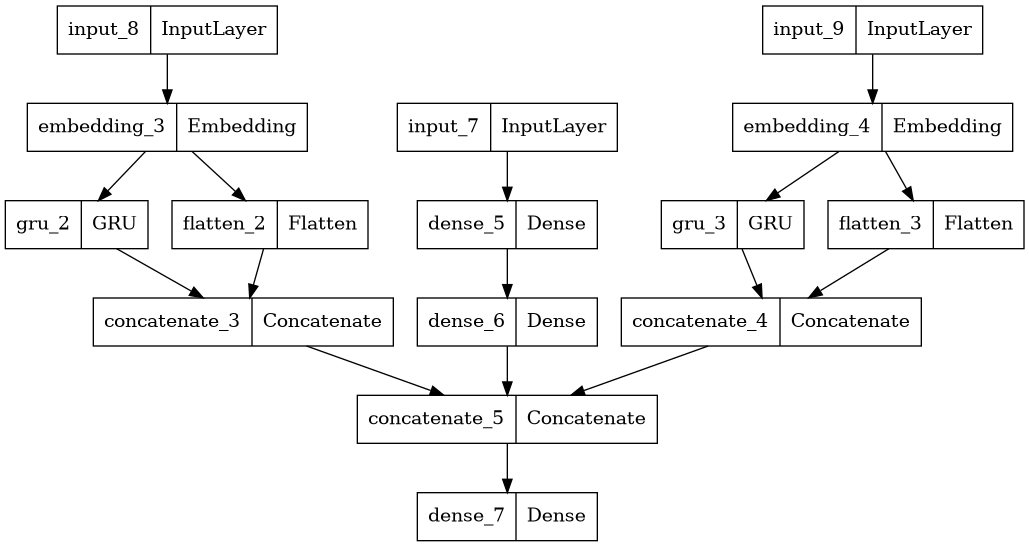

In [78]:
tf.keras.utils.plot_model(model)

### Training

In [79]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

batch_size=32
epochs=3

history = model.fit(
    [X_train, desc_train, tweets_train],
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('./model.h5', save_best_only=True, save_weights_only=True),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/3


2025-04-11 11:14:32.103045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-11 11:14:32.105032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-11 11:14:32.106883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

329/329 [==============================] - ETA: 0s - loss: 0.8658 - accuracy: 0.5757   

2025-04-11 11:17:40.471722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-11 11:17:40.473566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-11 11:17:40.475048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

329/329 [==============================] - 199s 591ms/step - loss: 0.8658 - accuracy: 0.5757 - val_loss: 0.7706 - val_accuracy: 0.6399 - lr: 0.0010
Epoch 2/3
329/329 [==============================] - 199s 604ms/step - loss: 0.3626 - accuracy: 0.8874 - val_loss: 0.8150 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 3/3
329/329 [==============================] - 203s 616ms/step - loss: 0.0935 - accuracy: 0.9803 - val_loss: 0.8632 - val_accuracy: 0.6487 - lr: 0.0010


In [80]:
model.load_weights('model.h5')

### Results

In [81]:
results = model.evaluate([X_test, desc_test, tweets_test], y_test)
print("Model Accuracy: {:.2f}%".format(results[1]*100))

177/177 [==============================] - 27s 151ms/step - loss: 0.7567 - accuracy: 0.6496
Model Accuracy: 64.96%


In [82]:
y_true = np.array(y_test)

y_pred = model.predict([X_test, desc_test, tweets_test])
y_pred = map(lambda x: np.argmax(x), y_pred)
y_pred = np.array(list(y_pred))

2025-04-11 11:31:20.744589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-11 11:31:20.748487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-11 11:31:20.752112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

177/177 [==============================] - 29s 161ms/step


In [83]:
y_true

array([1, 1, 2, ..., 1, 2, 1])

In [84]:
y_pred

array([1, 0, 2, ..., 2, 2, 0])

In [85]:
cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=['Female', 'Male', 'Brand'])

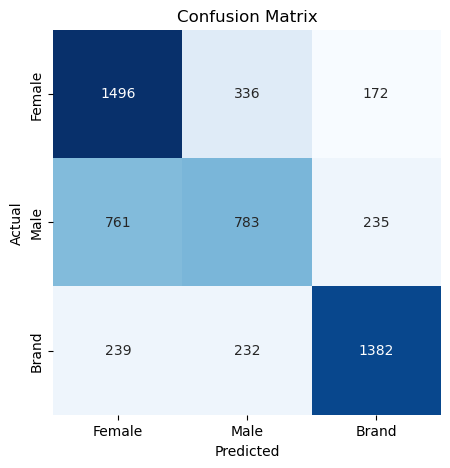

Classification Report: 

               precision    recall  f1-score   support

      Female       0.60      0.75      0.66      2004
        Male       0.58      0.44      0.50      1779
       Brand       0.77      0.75      0.76      1853

    accuracy                           0.65      5636
   macro avg       0.65      0.64      0.64      5636
weighted avg       0.65      0.65      0.64      5636



In [88]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3)+0.5, ['Female', 'Male', 'Brand'])
plt.yticks(np.arange(3)+0.5, ['Female', 'Male', 'Brand'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report: \n\n", clr)